In [280]:
import pandas as pd
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
import random
import pickle

In [325]:
def cMGRM(theta, alpha=1.5, b=0.5, c=0):
    # MGRM cumulative probability
    return math.e**(alpha*(theta-b+c))/(1+math.e**(alpha*(theta-b+c)))

def cMGRM_user_df(data, theta, c):
    # Matrix operation
    return math.e**(data['alpha']*(theta-data['b']+c))/(1+math.e**(data['alpha']*(theta-data['b']+c)))

def cMGRM_exc_df(data, alpha, b, c):
    # Matrix operation
    return math.e**(alpha*(data['theta']-b+c))/(1+math.e**(alpha*(data['theta']-b+c)))

def model(theta, alpha, b, cl=[1,0,-0.6], start=1):
    sum = start*1
    for c in cl:
        sum += cMGRM(theta, alpha, b, c)
    return sum

def model_user_df(data, theta, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
    for c in cl:
        sum += cMGRM_user_df(data, theta, c)
    return sum

def model_exc_df(data, alpha, b, cl, start=1):
    sum = pd.Series(np.zeros(len(data)))
    sum += start*1
    for c in cl:
        sum += cMGRM_exc_df(data, alpha, b, c)
        
    return sum

def partial_derivative_model_alpha(theta, alpha, b, cl):
    # partial derivative of model to alpha
    sum = 0
    for c in cl:
        curr = cMGRM(theta, alpha, b, c)*(1-cMGRM(theta, alpha, b, c))*math.e**(alpha*(theta-b+c))*(theta-b+c)
        sum += curr
        
    return sum

def partial_derivative_model_b(theta, alpha, b, cl):
    # partial derivative of model to b
    sum = 0
    for c in cl:
        curr = cMGRM(theta, alpha, b, c)*(1-cMGRM(theta, alpha, b, c))*math.e**(alpha*(theta-b+c))*(-alpha)
        sum += curr
        
    return sum
        

def partial_derivative_model_theta(theta, alpha, b, cl):
    # partial derivative of model to theta
    sum = 0
    for c in cl:
        curr = cMGRM(theta, alpha, b, c)*(1-cMGRM(theta, alpha, b, c))*math.e**(alpha*(theta-b+c))*(alpha)
        sum += curr
        
    return sum

def partial_derivative_loss(theta, alpha, b, cl, y):
    # partial derivative of loss function to alpha
    # loss = (model(theta)-y))**2
    
    gradient_alpha = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_alpha(theta, alpha, b, cl)
    gradient_b = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_b(theta, alpha, b, cl)
    gradient_theta = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_theta(theta, alpha, b, cl)
    
    return [gradient_alpha, gradient_b, gradient_theta]

def partial_derivative_model_alpha2_b2_df(data, alpha, b, cl):
    # partial derivative of model to alpha
    
    g_alpha = 0
    g_b = 0
    
    
    for c in cl:
        curr = cMGRM_exc_df(data, alpha, b, c)*(1-cMGRM_exc_df(data, alpha, b, c))*(-data['theta']+b-c)
        g_alpha += curr
        curr = cMGRM_exc_df(data, alpha, b, c)*(1-cMGRM_exc_df(data, alpha, b, c))*(alpha)
        g_b += curr
        
    return g_alpha, g_b



def partial_derivative_model_theta2_df(data, theta, cl):
    # partial derivative of model to theta
    g_theta = 0
    for c in cl:
        curr = cMGRM_user_df(data,theta, c)*(1-cMGRM_user_df(data,theta, c))*(-data['alpha'])
        g_theta += curr
     
    return g_theta

def partial_derivative_loss2(theta, alpha, b, cl, y):
    # partial derivative of loss function to alpha
    # loss = (model(theta)-y))**2
    
    gradient_alpha = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_alpha2(theta, alpha, b, cl)
    gradient_b = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_b2(theta, alpha, b, cl)
    gradient_theta = 2*(model(theta, alpha, b, cl)-y)*partial_derivative_model_theta2(theta, alpha, b, cl)
    
    return [gradient_alpha, gradient_b, gradient_theta]

def loss(theta, alpha, b, cl, y):
    return (model(theta, alpha, b, cl)-y)**2

def sum_loss(data, parameters, cl):
    sum = 0
    uid_p, exc_p = parameters
    for index, group in data.groupby(['day', 'uid', 'exc_num']):
        day, uid, exc = index
        alpha = exc_p.loc[exc_p.exc_num==exc, 'alpha'].reset_index(drop=True)[0]
        b = exc_p.loc[exc_p.exc_num==exc, 'b'].reset_index(drop=True)[0]
        theta = uid_p.loc[(uid_p.day==day) & (uid_p.uid==uid), 'theta'].reset_index(drop=True)[0]
        y = group['performance'].reset_index(drop=True)[0]
        curr = loss(theta, alpha, b, cl, y)
        sum += curr
        
    mean = sum/len(data)
    return sum, mean

def calc_gradient_user(data, parameters, cl):
    # calc sum loss for a certain user, so we select all loss by this user
    gradient_theta = pd.DataFrame()
    uid_p, exc_p = parameters
    
    days = data['day'].unique()
    
    for day in days:
        tmp = uid_p[uid_p['day'] == day]
        uids = tmp['uid'].unique()
        for uid in uids:
            tmp2 = tmp[tmp['uid'] == uid]
            tmp2 = tmp2.reset_index()
            theta = tmp2['theta'][0]
            
            excs = data.set_index(['day', 'uid']).loc[(day, uid), 'exc_num'].unique()
            excs_para_of_a_certain_user = exc_p.set_index(['exc_num']).loc[(excs)].reset_index()
            
            expected_value = model_user_df(excs_para_of_a_certain_user, theta=theta, cl=cl)
            
            y = data.set_index(['day', 'uid']).loc[(day, uid), ['exc_num', 'performance']]
            excs2 = y['exc_num']
            assert np.array_equal(excs, excs2.as_matrix()), \
            'false alignment between expected value and average value'
            y = y['performance'].reset_index(drop=True)
               
            diff = expected_value-y
            g_theta = partial_derivative_model_theta2_df(excs_para_of_a_certain_user, theta, cl)
            g_theta = 2*np.sum(diff*g_theta)
            
            
            curr = pd.DataFrame(np.array([day, uid, g_theta]).reshape(1,-1), columns=['day', 'uid', 'theta'])
            gradient_theta = pd.concat([gradient_theta, curr])
     
    gradient_theta = gradient_theta.reset_index(drop=True)
    return gradient_theta

def calc_gradient_exc(data, parameters, cl):
    # calc sum loss for a certain exercise, so we select all loss by this exercise
    gradient_alpha_b = pd.DataFrame()
    uid_p, exc_p = parameters
    
    excs = data['exc_num'].unique()
    for exc in excs:
        
        tmp = exc_p[exc_p['exc_num']==exc].reset_index()
        alpha = tmp['alpha'][0]
        b = tmp['b'][0]
        days = data.loc[data.exc_num==exc, 'day'].unique()
        
        for day in days:
            tmp2 = uid_p[uid_p['day'] == day]
            uids = data.set_index(['day', 'exc_num']).loc[(day, exc), 'uid'].unique()
            tmp2 = tmp2.set_index(['uid']).loc[uids].reset_index(drop=True)
            
            expected_value = model_exc_df(tmp2, alpha, b, cl)
            y = data.loc[(data.day==day)&(data.exc_num==exc), ['uid', 'performance']]
            y = y.set_index(['uid']).loc[uids, 'performance'].reset_index(drop=True)
#             loss = np.sum(expected_value-y)
            diff = expected_value-y
            g_alpha, g_b = partial_derivative_model_alpha2_b2_df(tmp2, alpha, b, cl)
            g_alpha = 2*np.sum(diff*g_alpha)
            g_b = 2*np.sum(diff*g_b)
            
            
            curr = pd.DataFrame(np.array([exc, g_alpha, g_b]).reshape(1,-1), columns=['exc_num', 'alpha', 'b'])
            gradient_alpha_b = pd.concat([gradient_alpha_b, curr])
            
    gradient_alpha_b = gradient_alpha_b.groupby(['exc_num']).sum().reset_index()
    
    return gradient_alpha_b
    
    
    
def calc_gradient_vector(data, parameters):
    # consider the ability of the same person in different training day as different
    uid_p, exc_p = parameters
    cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
          -0.059, -0.103, -0.156, -0.394, -0.415,
          -0.478, -1.377, -1.471, -1.989]
    
    sum_loss = 0
    
    uid_gradient = pd.DataFrame(np.array([]).reshape(0, 3), columns=['uid', 'day', 'theta_g'])
    exc_gradient = pd.DataFrame(np.array([]).reshape(0, 3), columns=['exc_num', 'alpha_g', 'b_g'])
    
    for day in xrange(5):
        day_data = data_day1= data[data['day']==day+1]
        if len(day_data) == 0:
            continue
        
        groups = day_data.groupby(['exc_num', 'uid'])
        
        for index, group in groups:
            
            exc_num, uid = index
            theta = uid_p.set_index(['uid', 'day']).loc[(uid, day+1)].tolist()[0]
            
            alpha = exc_p.set_index(['exc_num']).loc[exc_num, 'alpha']
            b = exc_p.set_index(['exc_num']).loc[exc_num, 'b']
            y = group['performance'].tolist()[0]
        
            
            gradient_alpha, gradient_b, gradient_theta = partial_derivative_loss(theta, alpha, b, cl, y)
            curr1 = pd.DataFrame(np.array([uid, day+1, gradient_theta]).reshape(1,3), 
                                 columns=['uid', 'day', 'theta_g'])
            curr2 = pd.DataFrame(np.array([exc_num, gradient_alpha, gradient_b]).reshape(1,3), 
                                 columns=['exc_num', 'alpha_g', 'b_g'])
            
            
            uid_gradient = uid_gradient.append(curr1, ignore_index=True)
            exc_gradient = exc_gradient.append(curr2, ignore_index=True)
            
            sum_loss += loss(theta, alpha, b, cl, y)
            
    mean_loss = sum_loss/len(data)
    return ([uid_gradient, exc_gradient], sum_loss, mean_loss)

def calc_gradient_vector_df(data, parameters, cl):
    gradient_alpha 
    alphas = sum_loss_exc(data, parameters, cl)*calc_

def update(parameter, gradient, alpha=0.001):
    uid_p, exc_p = parameters
    uid_gradient, exc_gradient = gradient
    
    # calc average theta gradient by each user in each day
    uid_avg = uid_gradient.groupby(['uid', 'day']).mean()    
    # calc average alpha and b by each exercise
    exc_avg = exc_gradient.groupby(['exc_num']).mean()
    
    uid_step = uid_avg*alpha
    exc_step = exc_avg*alpha
    
    uid_result = pd.concat([uid_p.set_index(['uid', 'day']), uid_step], join='inner', axis=1)
    exc_result = pd.concat([exc_p.set_index(['exc_num']), exc_step], join='inner', axis=1)
    
    uid_result['theta'] -= uid_result['theta_g']
    exc_result['alpha'] -= exc_result['alpha_g']
    exc_result['b'] -= exc_result['b_g']
    
    return [uid_result.reset_index()[['uid', 'day', 'theta']], exc_result.reset_index()[['exc_num', 'alpha', 'b']]]

def update2(parameter, g_alpha_b, g_theta, alpha=0.001):
    uid_p, exc_p = parameters
    uid_p = uid_p.set_index(['day','uid']) + alpha*g_theta.set_index(['day', 'uid'])
    exc_p = exc_p.set_index(['exc_num']) + alpha*g_alpha_b.set_index(['exc_num'])
    return uid_p.reset_index(), exc_p.reset_index()
    
    
def initial_parameters(data):
    
    
    uid_p = pd.DataFrame(np.array([]).reshape(0, 3), columns=['uid', 'day', 'theta'])
    exc_p = pd.DataFrame(np.array([]).reshape(0, 3), columns=['exc_num', 'alpha', 'b'])
    days = data['day'].unique()
    
    # compare average score over all exercises of different user
    avg_perf = data[['exc_num', 'uid', 'performance']].groupby(['exc_num', 'uid']).mean()
    count = avg_perf.reset_index()[['exc_num']]
    count['count'] = 0
    count = count[['exc_num', 'count']].groupby(['exc_num']).count()
    excs = count[count['count']== count['count'].max()].reset_index()['exc_num'].unique()
    avg_perf = avg_perf.reset_index().set_index(['exc_num']).loc[excs]
    avg_perf = avg_perf.reset_index().groupby(['exc_num', 'uid']).mean()
    avg_perf = avg_perf.reset_index().groupby(['uid']).mean()
    
    # transform average score in range of [-3, 3]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['theta'] = (avg_perf['performance']-min_perf)/interval*6-3
    
    curr = avg_perf.reset_index()[['uid', 'theta']]
    
    for day in xrange(5):
        day += 1
        if day not in days:
            continue
        curr['day'] = day
        uid_p = pd.concat([uid_p, curr])
        
    
    #################################
    # compare average score over all user of different exercises
    avg_perf = data[['exc_num', 'uid', 'performance']].groupby(['exc_num', 'uid']).mean()
    count = avg_perf.reset_index()[['uid', 'performance']].groupby(['uid']).count()
    uids = count[count['performance']== count['performance'].max()].reset_index()['uid'].unique()
    avg_perf = avg_perf.reset_index().set_index(['uid']).loc[uids]
    avg_perf = avg_perf.reset_index().groupby(['exc_num', 'uid']).mean()
    avg_perf = avg_perf.reset_index().groupby(['exc_num']).mean()
    
    
    # use average score to represent exercise difficulty, and transform them in range of [-2, 2]
    max_perf = avg_perf['performance'].max()
    min_perf = avg_perf['performance'].min()
    interval = max_perf-min_perf
    
    avg_perf['b'] = (avg_perf['performance']-min_perf)/interval*4-2
    avg_perf['b'] = avg_perf['b']*-1
    
    avg_perf = avg_perf.reset_index()
    avg_perf['alpha'] = pd.Series(1.5*np.random.random_sample(len(avg_perf)))
    
    exc_p = avg_perf[['exc_num', 'alpha', 'b']]
    uid_p = uid_p.reset_index(drop=True)
    exc_p = exc_p.reset_index(drop=True)
    
    return uid_p, exc_p
    
    
def select_exc(data, selected_excs=None, selected_day=None, delete=None):
        
    if selected_excs is None or len(selected_excs)==0:
        pass
    else:
        data = data.set_index(['exc_num'])
        data = data.loc[selected_excs]
        data = data.reset_index()
        
    if delete is not None:
        tmp = pd.DataFrame()
        groups = data.groupby(['day', 'exc_num'])
        for index, group in groups:
            if index in delete:
                continue
            tmp = pd.concat([tmp, group])
        data = tmp
        del tmp
    
    if selected_day is not None:
        data = data[data['day']==selected_day]
        data = data.reset_index(drop=True)
    return data

In [321]:
cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
          -0.059, -0.103, -0.156, -0.394, -0.415,
          -0.478, -1.377, -1.471, -1.989]
parameters = initial_parameters(expected_performance)
uid, exc = parameters
g_theta = calc_gradient_user(expected_performance, parameters, cl)
g_alpha_b = calc_gradient_exc(expected_performance, parameters, cl)
# print(g_alpha_b)
parameters = update2(parameters, g_alpha_b, g_theta)

s_loss, mean_loss = sum_loss(expected_performance, parameters, cl)
print('mean loss is: '+str(mean_loss))
print('sum loss is: '+str(s_loss))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:307: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


mean loss is: 23.0034288108
sum loss is: 598.089149081


In [298]:
# uid_p, exc_p = parameters
# cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
#           -0.059, -0.103, -0.156, -0.394, -0.415,
#           -0.478, -1.377, -1.471, -1.989]
# tmp = partial_derivative_model_alpha2_b2_df(uid_p, 1,1, cl)
# tmp

In [284]:
expected_performance = pd.read_csv('../data/step2_expected_performance.csv')
expected_performance.head()

,day,exc_num,uid,performance
0,1,0.1,1,3.000000
1,1,0.1,4,3.000000
2,1,0.1,5,6.000000
3,1,0.1,7,4.333333
4,1,1.1,1,3.000000


In [290]:
selected_excs = [0.1, 1.2, 1.3, 1.5]
selected_day = 2
expected_performance = select_exc(expected_performance, selected_excs, selected_day)
expected_performance

,exc_num,day,uid,performance
0,0.1,2,7,4.500000
1,0.1,2,10,3.000000
2,0.1,2,11,11.000000
3,1.2,2,3,7.000000
4,1.2,2,6,4.000000
5,1.2,2,7,6.000000
6,1.2,2,11,8.000000
7,1.3,2,1,8.000000
8,1.3,2,2,4.000000
9,1.3,2,3,5.000000


In [326]:
cl = [1.359, 1.1, 0.919, 0.782, 0.62, 0.418, 0.388, 0.075, -0.054, -0.056, 
          -0.059, -0.103, -0.156, -0.394, -0.415,
          -0.478, -1.377, -1.471, -1.989]

try:
    parameters = pickle.load(open('../data/irt_parameters.p', 'rb'))
    
except:
    print('no parameter file')
    parameters = initial_parameters(expected_performance)
    print(parameters)

for i in xrange(1000):
    g_alpha_b = calc_gradient_exc(expected_performance, parameters, cl)
    g_theta = calc_gradient_user(expected_performance, parameters, cl)
    parameters = update2(parameters, g_alpha_b, g_theta)
    
    if i%100 ==1:
        s_loss, mean_loss = sum_loss(expected_performance, parameters, cl)
        print('mean loss is: '+str(mean_loss))
        print('sum loss is: '+str(s_loss))

no parameter file
(   day    theta   uid
0  2.0  1.50000   1.0
1  2.0 -1.50000   2.0
2  2.0  0.75000   3.0
3  2.0  1.87500   4.0
4  2.0  1.87500   5.0
5  2.0 -0.37500   6.0
6  2.0 -1.78125   7.0
7  2.0  3.00000   8.0
8  2.0 -3.00000  10.0
9  2.0  0.18750  11.0,    exc_num     alpha     b
0      0.1  0.303230 -2.00
1      1.2  0.604228 -1.04
2      1.3  0.593663 -0.40
3      1.5  1.045874  2.00)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:307: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:148: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


mean loss is: 18.0832870596
sum loss is: 470.165463549
mean loss is: 0.732746164798
sum loss is: 19.0514002848
mean loss is: 0.493980812414
sum loss is: 12.8435011228
mean loss is: 0.644523973389
sum loss is: 16.7576233081
mean loss is: 0.563176029729
sum loss is: 14.642576773
mean loss is: 0.515875630209
sum loss is: 13.4127663854
mean loss is: 0.484800193518
sum loss is: 12.6048050315
mean loss is: 0.467443939554
sum loss is: 12.1535424284
mean loss is: 0.457953170984
sum loss is: 11.9067824456
mean loss is: 0.451457139096
sum loss is: 11.7378856165


In [33]:
try:
    parameters = pickle.load(open('../data/irt_parameters.p', 'rb'))
    
except:
    print('no parameter file')
    parameters = initial_parameters(expected_performance)
    print(parameters)

for i in xrange(100000):
    gradients, sum_loss, mean_loss = calc_gradient_vector(expected_performance, parameters)
    parameters = update(parameters, gradients)
    
    if i%100 ==1:
        print('mean loss is: '+str(mean_loss))
        print('sum loss is: '+str(sum_loss))

mean loss is: 0.40275715681
sum loss is: 10.4716860771
mean loss is: 0.402748083188
sum loss is: 10.4714501629
mean loss is: 0.402739257204
sum loss is: 10.4712206873
mean loss is: 0.402730675186
sum loss is: 10.4709975548
mean loss is: 0.402722333516
sum loss is: 10.4707806714
mean loss is: 0.40271422863
sum loss is: 10.4705699444
mean loss is: 0.402706357014
sum loss is: 10.4703652824
mean loss is: 0.402698715203
sum loss is: 10.4701665953
mean loss is: 0.402691299782
sum loss is: 10.4699737943
mean loss is: 0.402684107386
sum loss is: 10.469786792
mean loss is: 0.402677134692
sum loss is: 10.469605502
mean loss is: 0.402670378427
sum loss is: 10.4694298391
mean loss is: 0.402663835361
sum loss is: 10.4692597194
mean loss is: 0.402657502308
sum loss is: 10.46909506
mean loss is: 0.402651376126
sum loss is: 10.4689357793
mean loss is: 0.402645453715
sum loss is: 10.4687817966
mean loss is: 0.402639732015
sum loss is: 10.4686330324
mean loss is: 0.402634208009
sum loss is: 10.468489408

mean loss is: 0.402828759475
sum loss is: 10.4735477464
mean loss is: 0.402833367494
sum loss is: 10.4736675548
mean loss is: 0.402837985801
sum loss is: 10.4737876308
mean loss is: 0.402842613915
sum loss is: 10.4739079618
mean loss is: 0.402847251362
sum loss is: 10.4740285354
mean loss is: 0.402851897675
sum loss is: 10.4741493396
mean loss is: 0.402856552397
sum loss is: 10.4742703623
mean loss is: 0.402861215074
sum loss is: 10.4743915919
mean loss is: 0.402865885263
sum loss is: 10.4745130168
mean loss is: 0.402870562527
sum loss is: 10.4746346257
mean loss is: 0.402875246434
sum loss is: 10.4747564073
mean loss is: 0.402879936562
sum loss is: 10.4748783506
mean loss is: 0.402884632493
sum loss is: 10.4750004448
mean loss is: 0.402889333818
sum loss is: 10.4751226793
mean loss is: 0.402894040133
sum loss is: 10.4752450435
mean loss is: 0.402898751042
sum loss is: 10.4753675271
mean loss is: 0.402903466153
sum loss is: 10.47549012
mean loss is: 0.402908185083
sum loss is: 10.47561

mean loss is: 0.403467723744
sum loss is: 10.4901608174
mean loss is: 0.403471259742
sum loss is: 10.4902527533
mean loss is: 0.403474781867
sum loss is: 10.4903443285
mean loss is: 0.403478290118
sum loss is: 10.4904355431
mean loss is: 0.403481784495
sum loss is: 10.4905263969
mean loss is: 0.403485265001
sum loss is: 10.49061689
mean loss is: 0.403488731636
sum loss is: 10.4907070225
mean loss is: 0.403492184403
sum loss is: 10.4907967945
mean loss is: 0.403495623308
sum loss is: 10.490886206
mean loss is: 0.403499048353
sum loss is: 10.4909752572
mean loss is: 0.403502459545
sum loss is: 10.4910639482
mean loss is: 0.40350585689
sum loss is: 10.4911522791
mean loss is: 0.403509240394
sum loss is: 10.4912402502
mean loss is: 0.403512610065
sum loss is: 10.4913278617
mean loss is: 0.403515965912
sum loss is: 10.4914151137
mean loss is: 0.403519307944
sum loss is: 10.4915020065
mean loss is: 0.403522636171
sum loss is: 10.4915885404
mean loss is: 0.403525950602
sum loss is: 10.4916747

mean loss is: 0.40384889451
sum loss is: 10.5000712573
mean loss is: 0.403850646194
sum loss is: 10.5001168011
mean loss is: 0.403852388358
sum loss is: 10.5001620973
mean loss is: 0.403854121039
sum loss is: 10.500207147
mean loss is: 0.403855844275
sum loss is: 10.5002519512
mean loss is: 0.403857558106
sum loss is: 10.5002965108
mean loss is: 0.40385926257
sum loss is: 10.5003408268
mean loss is: 0.403860957704
sum loss is: 10.5003849003
mean loss is: 0.403862643547
sum loss is: 10.5004287322
mean loss is: 0.403864320137
sum loss is: 10.5004723236
mean loss is: 0.403865987512
sum loss is: 10.5005156753
mean loss is: 0.40386764571
sum loss is: 10.5005587884
mean loss is: 0.403869294768
sum loss is: 10.500601664
mean loss is: 0.403870934725
sum loss is: 10.5006443029
mean loss is: 0.403872565619
sum loss is: 10.5006867061
mean loss is: 0.403874187486
sum loss is: 10.5007288746
mean loss is: 0.403875800366
sum loss is: 10.5007708095
mean loss is: 0.403877404295
sum loss is: 10.50081251

mean loss is: 0.404023413101
sum loss is: 10.5046087406
mean loss is: 0.404024129883
sum loss is: 10.5046273769
mean loss is: 0.404024841868
sum loss is: 10.5046458886
mean loss is: 0.404025549081
sum loss is: 10.5046642761
mean loss is: 0.404026251546
sum loss is: 10.5046825402
mean loss is: 0.404026949287
sum loss is: 10.5047006815
mean loss is: 0.404027642328
sum loss is: 10.5047187005
mean loss is: 0.404028330693
sum loss is: 10.504736598
mean loss is: 0.404029014405
sum loss is: 10.5047543745
mean loss is: 0.404029693488
sum loss is: 10.5047720307
mean loss is: 0.404030367966
sum loss is: 10.5047895671
mean loss is: 0.404031037862
sum loss is: 10.5048069844
mean loss is: 0.404031703199
sum loss is: 10.5048242832
mean loss is: 0.404032364
sum loss is: 10.504841464
mean loss is: 0.404033020289
sum loss is: 10.5048585275
mean loss is: 0.404033672089
sum loss is: 10.5048754743
mean loss is: 0.404034319422
sum loss is: 10.504892305
mean loss is: 0.404034962311
sum loss is: 10.504909020

mean loss is: 0.404088101702
sum loss is: 10.5062906442
mean loss is: 0.404088325227
sum loss is: 10.5062964559
mean loss is: 0.40408854656
sum loss is: 10.5063022106
mean loss is: 0.404088765711
sum loss is: 10.5063079085
mean loss is: 0.404088982694
sum loss is: 10.50631355
mean loss is: 0.40408919752
sum loss is: 10.5063191355
mean loss is: 0.404089410201
sum loss is: 10.5063246652
mean loss is: 0.40408962075
sum loss is: 10.5063301395
mean loss is: 0.404089829177
sum loss is: 10.5063355586
mean loss is: 0.404090035495
sum loss is: 10.5063409229
mean loss is: 0.404090239716
sum loss is: 10.5063462326
mean loss is: 0.404090441851
sum loss is: 10.5063514881
mean loss is: 0.404090641912
sum loss is: 10.5063566897
mean loss is: 0.40409083991
sum loss is: 10.5063618377
mean loss is: 0.404091035857
sum loss is: 10.5063669323
mean loss is: 0.404091229764
sum loss is: 10.5063719739
mean loss is: 0.404091421643
sum loss is: 10.5063769627
mean loss is: 0.404091611506
sum loss is: 10.506381899

mean loss is: 0.404102732575
sum loss is: 10.5066710469
mean loss is: 0.404102737293
sum loss is: 10.5066711696
mean loss is: 0.404102741077
sum loss is: 10.506671268
mean loss is: 0.404102743934
sum loss is: 10.5066713423
mean loss is: 0.40410274587
sum loss is: 10.5066713926
mean loss is: 0.404102746889
sum loss is: 10.5066714191
mean loss is: 0.404102746997
sum loss is: 10.5066714219
mean loss is: 0.4041027462
sum loss is: 10.5066714012
mean loss is: 0.404102744504
sum loss is: 10.5066713571
mean loss is: 0.404102741914
sum loss is: 10.5066712898
mean loss is: 0.404102738435
sum loss is: 10.5066711993
mean loss is: 0.404102734074
sum loss is: 10.5066710859
mean loss is: 0.404102728834
sum loss is: 10.5066709497
mean loss is: 0.404102722723
sum loss is: 10.5066707908
mean loss is: 0.404102715744
sum loss is: 10.5066706093
mean loss is: 0.404102707904
sum loss is: 10.5066704055
mean loss is: 0.404102699208
sum loss is: 10.5066701794
mean loss is: 0.404102689661
sum loss is: 10.5066699

In [327]:
pickle.dump(parameters, open('../data/irt_parameters.p', 'wb'))

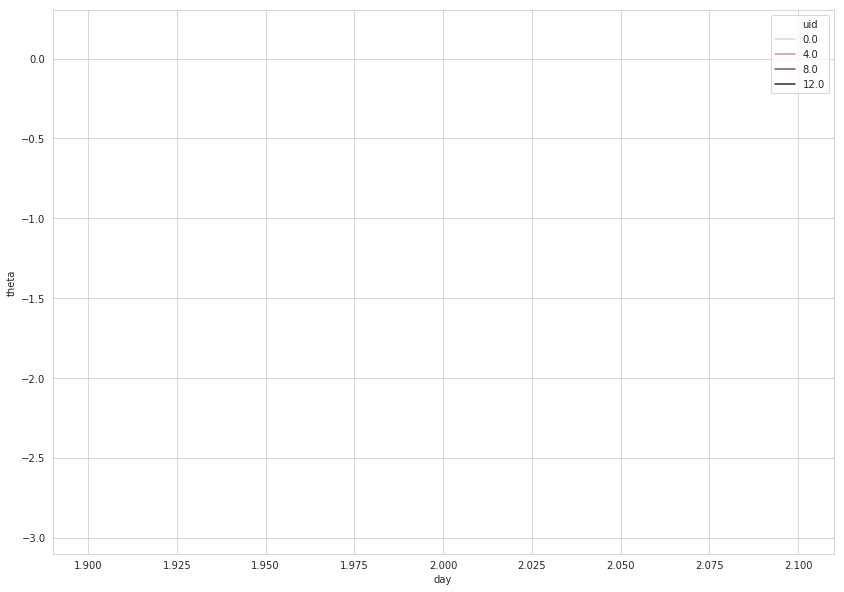

In [22]:
theta_day = parameters[0]
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.lineplot(x='day', y='theta', hue='uid', data=theta_day)
#     ax.set_title('exc_num is'+str(index))

In [328]:
parameters

(   day   uid     theta
 0  2.0   1.0  0.811170
 1  2.0   2.0 -1.938701
 2  2.0   3.0 -0.473703
 3  2.0   4.0  0.641702
 4  2.0   5.0  0.269241
 5  2.0   6.0 -1.846867
 6  2.0   7.0 -1.289662
 7  2.0   8.0  0.631750
 8  2.0  10.0 -2.290156
 9  2.0  11.0  0.103315,    exc_num     alpha         b
 0      0.1  1.194511  0.009296
 1      1.2  0.525048  1.048780
 2      1.3  0.312792  2.790258
 3      1.5  0.382282  2.624825)